<a href="https://colab.research.google.com/github/fouziyaMemon/CNNAssignmentMS/blob/main/FouziyaMemon_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: o build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


You can download the dataset here


The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

Actinic keratosis

---


Basal cell carcinoma


---


Dermatofibroma


---


Melanoma


---


Nevus


---


Pigmented benign keratosis


---


Seborrheic keratosis


---


Squamous cell carcinoma


---


Vascular lesion

### Import Libraries including TENSORFLOW

In [121]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [122]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### I have uploaded the extracted files to google drive to read the images of the dataset.

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [123]:
# Defining the path for train and test images
## Updated the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Test/')

In [124]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [125]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [126]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [127]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [128]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


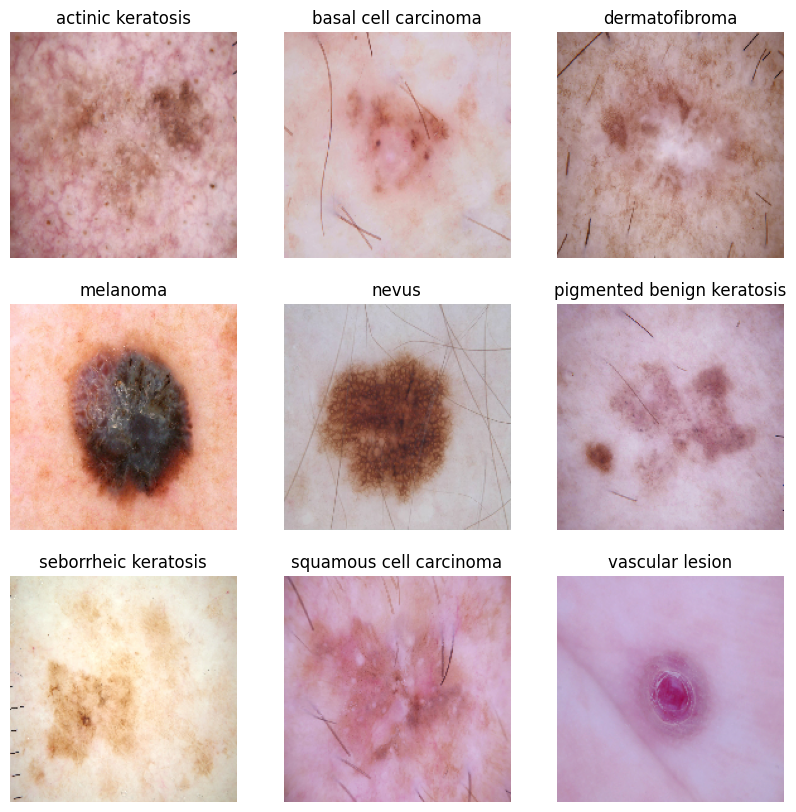

In [129]:
#Visualize one instance of all the class present in the dataset.
from tensorflow.keras.preprocessing.image import load_img

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [130]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [131]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [132]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [133]:
# View the summary of all layers
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_37 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

### Train the model

In [134]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 34s 149ms/step - loss: 2.0583 - accuracy: 0.1847 - val_loss: 2.0345 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 92ms/step - loss: 2.0309 - accuracy: 0.1908 - val_loss: 2.0313 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0126 - accuracy: 0.2148 - val_loss: 1.9821 - val_accuracy: 0.2170
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 1.9884 - accuracy: 0.2305 - val_loss: 1.9498 - val_accuracy: 0.2327
Epoch 5/20
56/56 [==============================] - 5s 94ms/step - loss: 2.0235 - accuracy: 0.2054 - val_loss: 2.0429 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 5s 91ms/step - loss: 2.0138 - accuracy: 0.1942 - val_loss: 2.0345 - val_accuracy: 0.2103
Epoch 7/20
56/56 [==============================] - 5s 92ms/step - loss: 2.0240 - accuracy: 0.1964 - val_loss: 2.0537 - val_accuracy: 0.2081
Epoch 8/20


### Visualizing training results

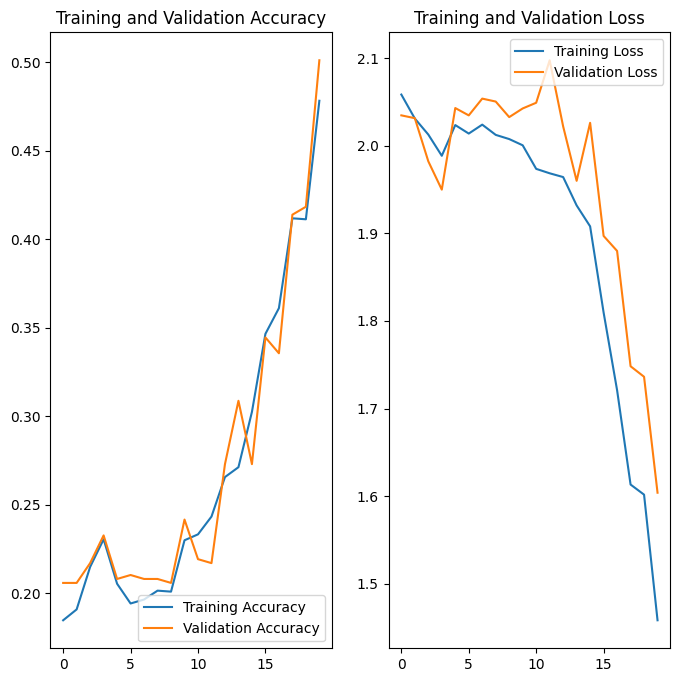

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Finding on the first base model**

- The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

- The accuracy is just around 75-80% because there are enough features to remember the pattern.

- But again, it's too early to comment on the overfitting & underfitting debate



In [136]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

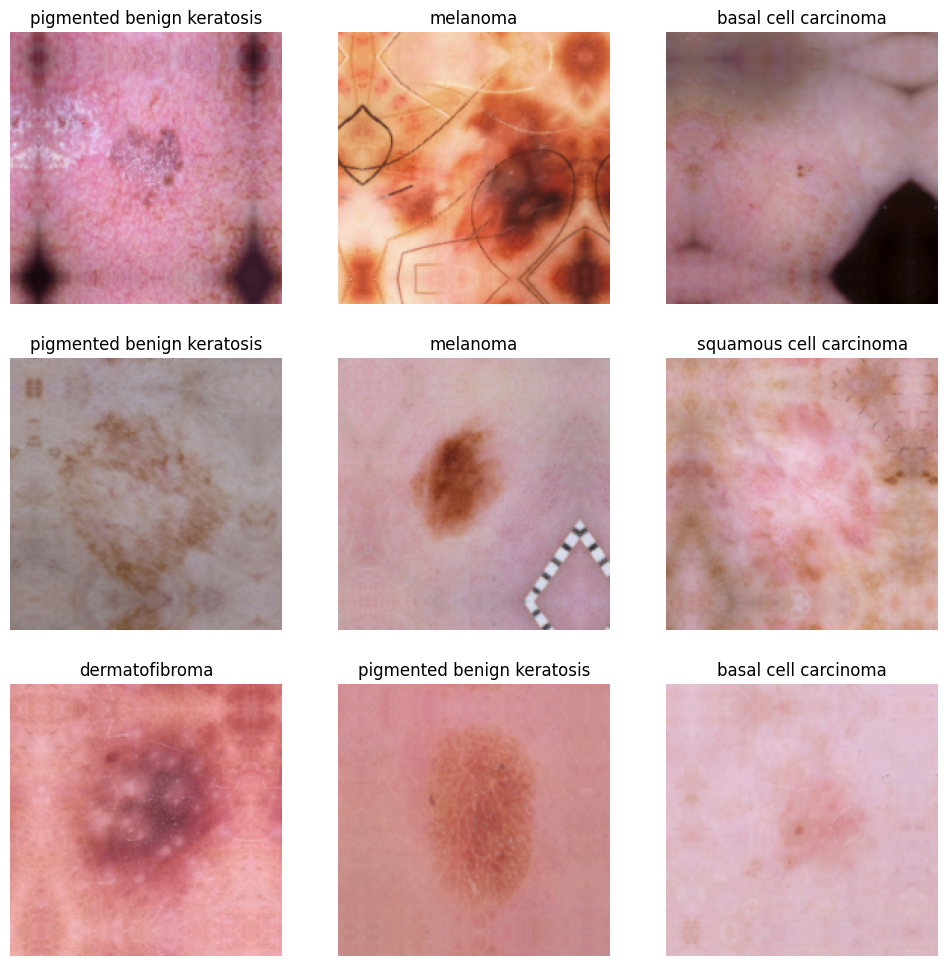

In [137]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model


In [138]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [139]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [140]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 113ms/step - loss: 2.0809 - accuracy: 0.1791 - val_loss: 2.1326 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 112ms/step - loss: 1.9976 - accuracy: 0.2249 - val_loss: 2.1209 - val_accuracy: 0.3132
Epoch 3/20
56/56 [==============================] - 6s 109ms/step - loss: 2.0297 - accuracy: 0.2087 - val_loss: 2.0290 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 6s 106ms/step - loss: 2.0292 - accuracy: 0.2104 - val_loss: 2.0258 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 6s 112ms/step - loss: 2.0182 - accuracy: 0.1987 - val_loss: 2.0140 - val_accuracy: 0.2282
Epoch 6/20
56/56 [==============================] - 6s 105ms/step - loss: 2.0248 - accuracy: 0.2104 - val_loss: 2.0260 - val_accuracy: 0.1924
Epoch 7/20
56/56 [==============================] - 6s 106ms/step - loss: 2.0151 - accuracy: 0.2048 - val_loss: 2.0237 - val_accuracy: 0.1544
Epoch 

### Visualizing the results

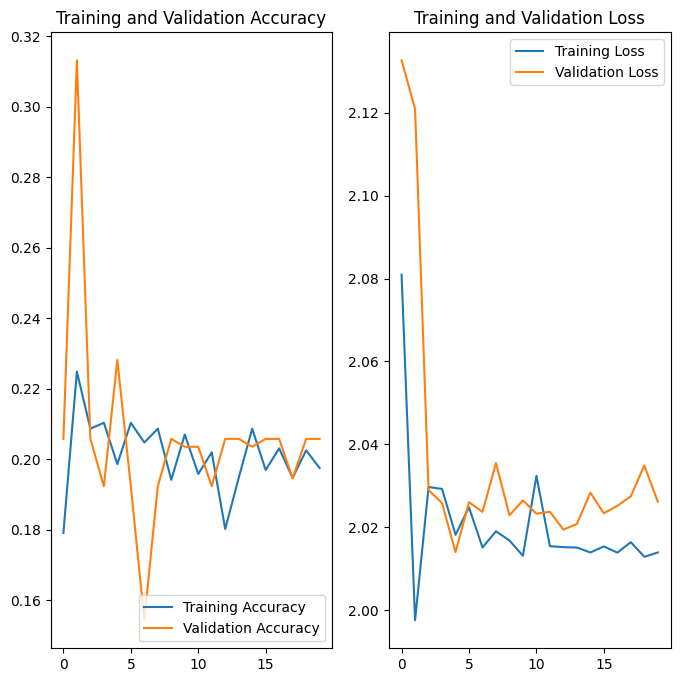

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Finding from Second Model**

- There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

- We can increase the epochs to increase the accuracy so it's too early for judgement

####  Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [142]:
##
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
1,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
2,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
3,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
4,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion
2235,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion
2236,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion
2237,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion


In [143]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
1,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
2,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
3,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
4,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion
2235,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion
2236,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion
2237,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion


<BarContainer object of 9 artists>

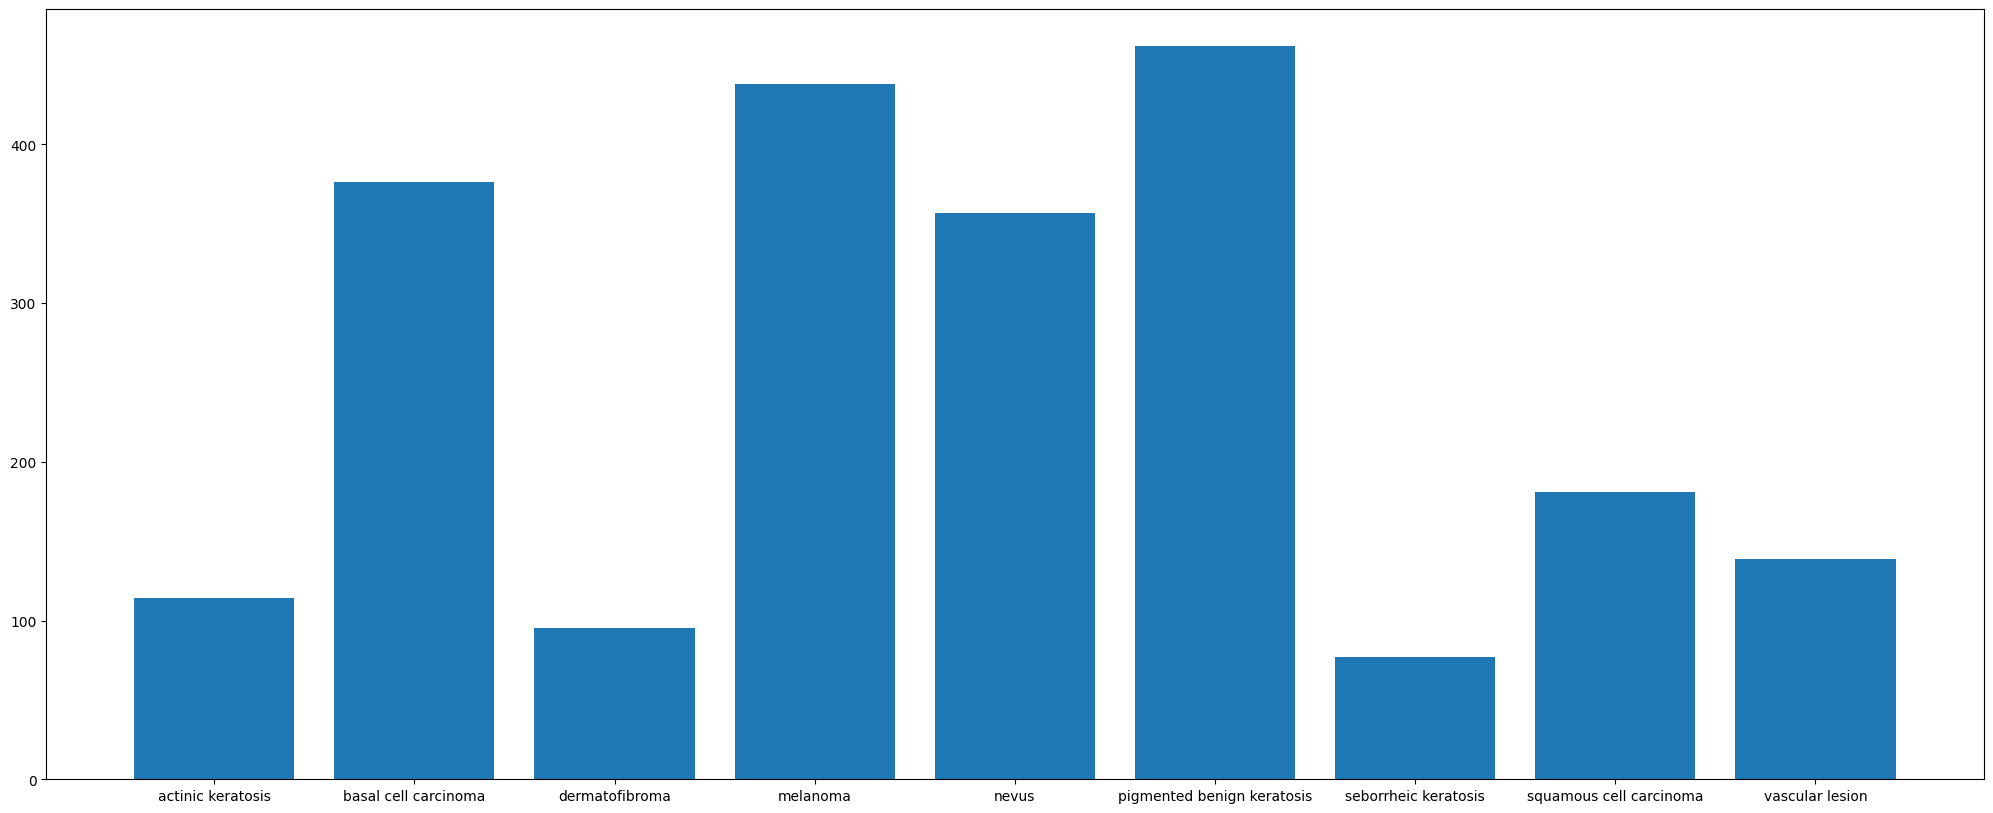

In [144]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Answer-1 :- **seborrheic Keratosis** has least number of samples

Answer-2:- **basal cell carcinoma and nevus** have proportionate number to dominate the samples.
**melanoma and pigmented benign keratosis** have proportionate number to dominate the samples.

In [145]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [146]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [147]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2BDAFFF250>: 100%|██████████| 500/500 [01:02<00:00,  8.01 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2C518319F0>: 100%|██████████| 500/500 [00:48<00:00, 10.31 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2BC79A4400>: 100%|██████████| 500/500 [00:51<00:00,  9.67 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2C1B950910>: 100%|██████████| 500/500 [00:41<00:00, 12.02 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2C51830C10>: 100%|██████████| 500/500 [00:48<00:00, 10.36 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7F2BD77526B0>: 100%|██████████| 500/500 [00:50<00:00,  9.85 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2BC7722260>: 100%|██████████| 500/500 [00:45<00:00, 10.96 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2C5171CAC0>: 100%|██████████| 500/500 [00:47<00:00, 10.55 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2BDAFA4880>: 100%|██████████| 500/500 [00:42<00:00, 11.74 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [148]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)


5000


In [149]:

for i in class_names:

    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
1,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
2,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
3,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
4,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,actinic keratosis
...,...,...
7234,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion
7235,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion
7236,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion
7237,/content/gdrive/MyDrive/CNNAssignmentFiles/ISI...,vascular lesion


### Lets see the distribution of augmented data after adding new images to the original training data.

In [150]:
new_df['Label'].value_counts()

pigmented benign keratosis    1469
melanoma                      1399
basal cell carcinoma          1234
nevus                         1125
squamous cell carcinoma        571
vascular lesion                471
actinic keratosis              390
dermatofibroma                 328
seborrheic keratosis           252
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [151]:
batch_size = 32
img_height = 180
img_width = 180

In [152]:
import pathlib
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train")

In [153]:
data_dir_train1

PosixPath('/content/gdrive/MyDrive/CNNAssignmentFiles/ISIC/Train')

####  Create a training dataset

In [154]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


In [155]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.


#### Create a validation dataset

In [156]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)

In [157]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

####  Compile your model (Choose optimizer and loss function appropriately)

In [158]:
## ### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [159]:
epochs =30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 58s 311ms/step - loss: nan - accuracy: 0.0191 - val_loss: nan - val_accuracy: 0.0230
Epoch 2/30
169/169 [==============================] - 44s 254ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 3/30
169/169 [==============================] - 43s 249ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 4/30
169/169 [==============================] - 41s 234ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 5/30
169/169 [==============================] - 43s 249ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 6/30
169/169 [==============================] - 40s 231ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 7/30
169/169 [==============================] - 45s 257ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 8/30
169/169 [==================

####  Visualize the model results

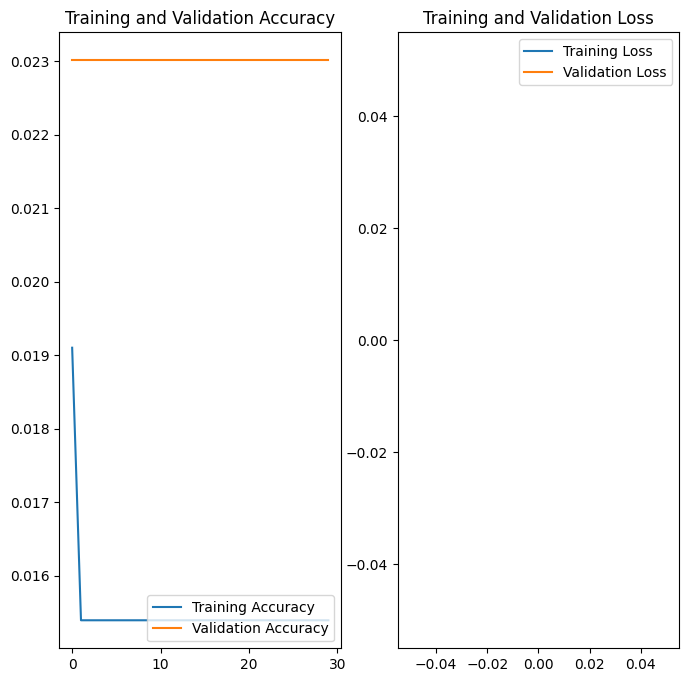

In [160]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting

- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter